In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

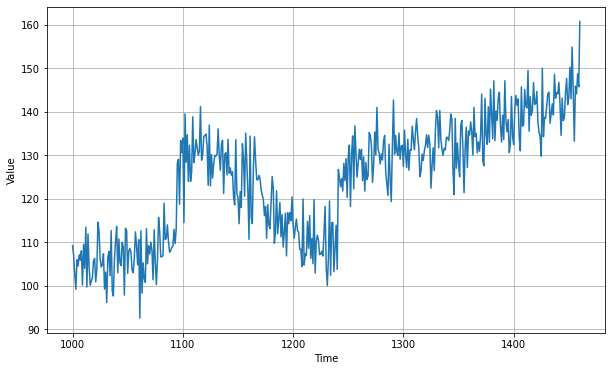

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [57]:
def get_shape(dataset):
    dataset_to_numpy = list(dataset.as_numpy_iterator())
    shape = tf.shape(dataset_to_numpy)
    return shape
    
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  print(type(dataset), get_shape(dataset))
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  #print(type(dataset), get_shape(dataset))
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  print(type(dataset), get_shape(dataset))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  #print(type(dataset), get_shape(dataset))
  dataset = dataset.batch(batch_size).prefetch(1)
  #print(type(dataset), get_shape(dataset))
  return dataset

In [58]:
print(window_size, batch_size, shuffle_buffer_size)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

30 32 1000
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> tf.Tensor([1000], shape=(1,), dtype=int32)
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'> tf.Tensor([970  31], shape=(2,), dtype=int32)


In [59]:
#dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


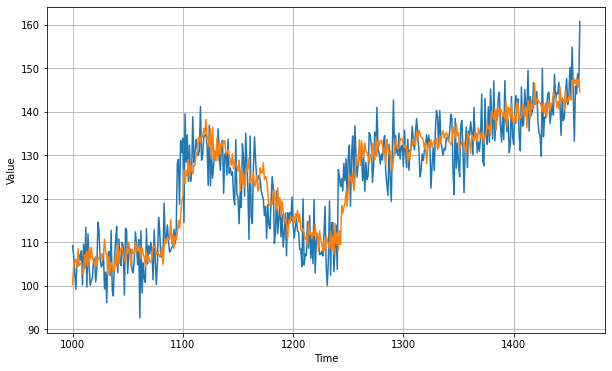

In [60]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7986674

In [62]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> tf.Tensor([1000], shape=(1,), dtype=int32)
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'> tf.Tensor([970  31], shape=(2,), dtype=int32)


(1e-08, 0.001, 0.0, 300.0)

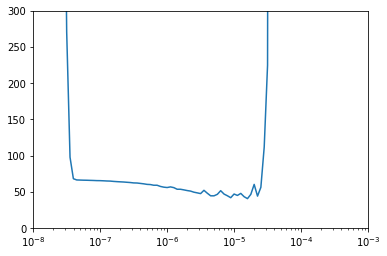

In [63]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [64]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> tf.Tensor([1000], shape=(1,), dtype=int32)
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'> tf.Tensor([970  31], shape=(2,), dtype=int32)


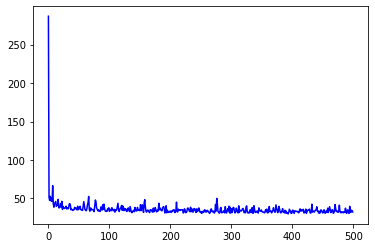

In [65]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[1058.8583984375, 842.822509765625, 745.6378784179688, 728.5128784179688, 720.8549194335938, 719.085693359375, 718.634033203125, 718.3689575195312, 718.2763671875, 717.3375244140625, 713.1837768554688, 708.4829711914062, 709.2415161132812, 707.529296875, 705.74609375, 704.333251953125, 704.4893798828125, 702.6666259765625, 703.6497802734375, 717.2401123046875, 718.7813720703125, 719.0740356445312, 718.7131958007812, 719.4629516601562, 719.213134765625, 718.6052856445312, 718.736328125, 718.9397583007812, 718.962646484375, 719.127197265625, 718.5673828125, 718.5952758789062, 718.9381103515625, 719.0541381835938, 718.7127075195312, 718.8118286132812, 718.8086547851562, 719.1299438476562, 718.8036499023438, 719.23193359375, 718.56396484375, 718.8875732421875, 718.6482543945312, 718.7081298828125, 718.781982421875, 718.5784301757812, 718.7972412109375, 718.701904296875, 718.624755859375, 718.6004028320312, 718.6339111328125, 718.9126586914062, 718.6144409179688, 718.6322631835938, 718.9322

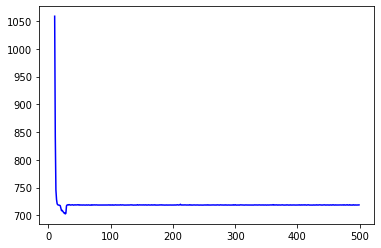

In [53]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

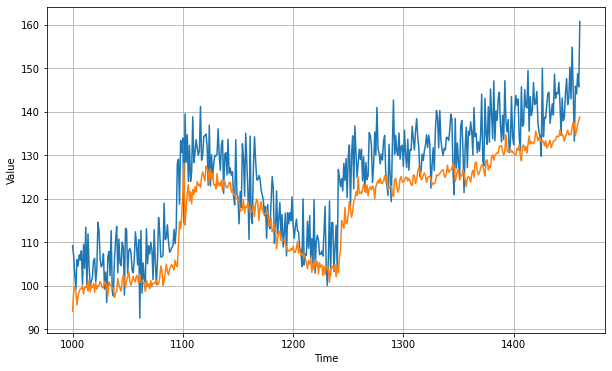

In [66]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.3563833